In [ ]:
%reset

### DOWNLOAD DATA

In [ ]:
import os
import requests

forest_fires = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv",
    "https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.names",
)

def dl_data(path='forest_fires', urls=forest_fires):
    if not os.path.exists(path):
        os.mkdir(path)
    for url in urls:
        response = requests.get(url)
        name = os.path.basename(url)
        with open(os.path.join(path, name), 'wb') as f:
            f.write(response.content)
            
dl_data()

### LOAD AND INITIAL CLEANING


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
fire = pd.read_csv('forest_fires/forestfires.csv')
fire.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [3]:
fire.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


#### very unbalanced dataset 

(448, 13)

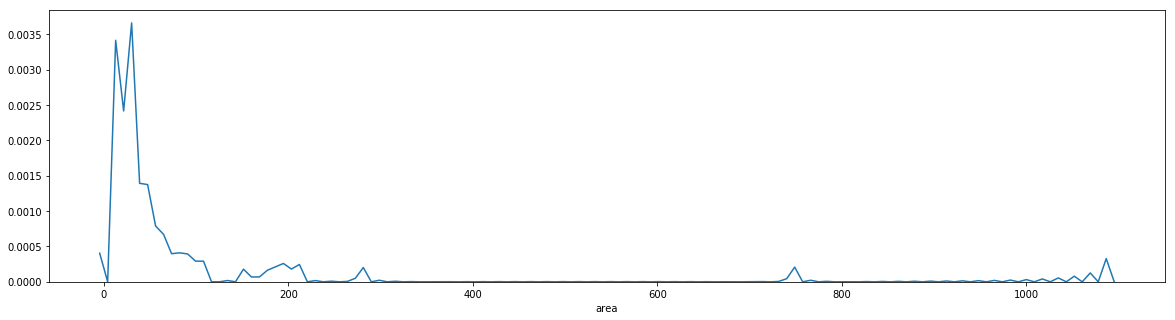

In [4]:
plt.figure(figsize=(20,5))
sns.distplot(fire.area, hist=False)
fire[fire['area']<15].shape

### MISSING VALUES

In [5]:
def missing_values(data):
    for i,j in list(zip(fire.columns, (data.isnull().sum()))):
        if j>1:
            print (f"{i}: missing {j}")
            
missing_values(fire)
# no missing data

### PRE-PROCESSING 

In [6]:
month_to_qtr = {'jan': 1, 'feb': 1, 'mar': 1, 
                'apr': 2, 'may': 2, 'jun': 2, 
                'jul': 3, 'aug': 3, 'sep': 3, 
                'oct': 4, 'nov': 4, 'dec': 4}
fire['month'] = fire['month'].apply(lambda x:month_to_qtr[x])

fire = fire.rename(columns= {'month':'qrt'})


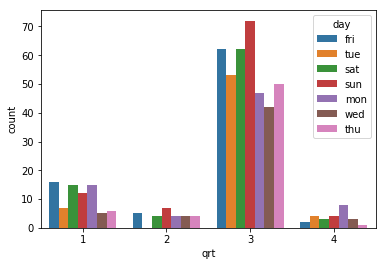

In [7]:
sns.countplot(x='qrt',data=fire,hue='day')

In [8]:
fire.head()

,X,Y,qrt,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,1,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,4,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,4,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,1,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,1,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [9]:
# del fire_clf

In [10]:
#### for binary classification
fire_clf =fire.copy()

### PIPELINE FOR SCALING AND ONEHOTENCODING

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import warnings
warnings.filterwarnings('ignore')

In [12]:
num_col = fire.select_dtypes(exclude='object').columns
num_col = num_col.drop(['area'])
cat_col = fire.select_dtypes(include='object').columns
num_col

Index(['X', 'Y', 'qrt', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind',
       'rain'],
      dtype='object')

In [13]:
num_trans = Pipeline(steps=[
    ('scaler',StandardScaler())])

cat_trans = Pipeline(steps=[
    ('ohe',OneHotEncoder())])

transformer = ColumnTransformer(transformers=[
    ('num',num_trans,num_col),
    ('cat', cat_trans,cat_col)
])


### FEATURE SELECTION

In [14]:
X = fire.drop(['area'], axis=1)
y = fire['area']
y = np.log1p(y)
y.describe()


count    517.000000
mean       1.111026
std        1.398436
min        0.000000
25%        0.000000
50%        0.418710
75%        2.024193
max        6.995620
Name: area, dtype: float64

### ML PART

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error,mean_absolute_error,accuracy_score
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.model_selection import GridSearchCV

# from sklearn.feature_selection import RFE

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator


import time
import datetime

In [16]:
reg_lin = LinearRegression()
reg_forest = RandomForestRegressor()
reg_tree = DecisionTreeRegressor()
reg_knn = KNeighborsRegressor()
reg_tree_ex = ExtraTreesRegressor()
reg_svr = SVR()

models = {'Linear Regression':reg_lin, 
         'Random Forest Regressor':reg_forest,
         'Decision Tree Regressor':reg_tree,
         'KNeighbors Regressor':reg_knn,
         'ExtraTrees Regressor':reg_tree_ex,
         'Support Vector Regression':reg_svr}


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
X_train.describe()

,X,Y,qrt,FFMC,DMC,DC,ISI,temp,RH,wind,rain
count,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000
mean,4.702842,4.271318,2.726098,90.789406,113.915245,560.526098,9.123256,19.079070,43.873385,4.006718,0.024806
std,2.329595,1.265844,0.746263,4.904050,63.919457,240.597059,4.626128,5.830006,15.621229,1.756765,0.337631
min,1.000000,2.000000,1.000000,50.400000,2.400000,15.300000,0.400000,2.200000,15.000000,0.400000,0.000000
25%,3.000000,4.000000,3.000000,90.300000,75.300000,474.900000,6.800000,15.900000,33.000000,2.700000,0.000000
50%,4.000000,4.000000,3.000000,91.700000,111.200000,665.300000,8.400000,19.400000,42.000000,4.000000,0.000000
75%,7.000000,5.000000,3.000000,92.900000,142.400000,714.700000,10.750000,22.800000,53.000000,4.900000,0.000000
max,9.000000,9.000000,4.000000,96.200000,291.300000,860.600000,56.100000,33.300000,96.000000,9.400000,6.400000


In [18]:
X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

In [19]:
errors = {}
for name,model in models.items():
    model.fit(X_train,y_train)
    predict = model.predict(X_test)
    error_sq = mean_squared_error(y_test,predict)
    error_abs = mean_absolute_error(y_test,predict)
    errors[name] =error_sq,error_abs
pd.DataFrame.from_dict(errors, orient='index', columns=["Mean Squared Error","Mean Absulute Error" ])   

,Mean Squared Error,Mean Absulute Error
Linear Regression,1.845807,1.178413
Random Forest Regressor,2.394830,1.296374
Decision Tree Regressor,3.983611,1.355032
KNeighbors Regressor,2.061934,1.181661
ExtraTrees Regressor,2.183242,1.193761
Support Vector Regression,1.902985,1.082364


### 100 FOLD CROSS VALIDATION -- WHY NOT :P

In [20]:
cv_scores = {}
scoring = ('neg_mean_squared_error','neg_mean_absolute_error' )
for name , model in models.items():
    start_time = time.time()
    cv = cross_validate(model, X_train, y_train, cv=100 ,n_jobs=-1, scoring=scoring)
    sq=np.mean(abs(cv['test_neg_mean_squared_error']))
    abs_=np.mean(abs(cv['test_neg_mean_absolute_error']))
    cv_scores[name] = sq,abs_
    print (f"{name} - Elapsed Time: {datetime.timedelta(seconds=time.time()-start_time)} ") 

pd.DataFrame.from_dict(cv_scores, orient='index', columns=["Mean Squared Error","Mean Absulute Error" ])   

Linear Regression - Elapsed Time: 0:00:04.791182 
Random Forest Regressor - Elapsed Time: 0:00:00.680178 
Decision Tree Regressor - Elapsed Time: 0:00:00.165578 
KNeighbors Regressor - Elapsed Time: 0:00:00.304166 
ExtraTrees Regressor - Elapsed Time: 0:00:00.419876 
Support Vector Regression - Elapsed Time: 0:00:00.408906 


,Mean Squared Error,Mean Absulute Error
Linear Regression,2.201142,1.192799
Random Forest Regressor,2.321070,1.201520
Decision Tree Regressor,4.034217,1.456873
KNeighbors Regressor,2.483821,1.237757
ExtraTrees Regressor,2.574468,1.229657
Support Vector Regression,2.234679,1.088039


### HYPERTUNNING

In [21]:
from sklearn.base import BaseEstimator
class DummyEstimator(BaseEstimator):
    def fit(self): pass
    def score(self): pass

cv_pipe = Pipeline([('estimator', DummyEstimator())])

# names= ["Random Forest Regressor",
#        "Decision Tree Regressor",
#        "KNeighbors Regressor",
#        "Support Vector Regression"]

regressors = dict()

regressors["Random Forest Regressor"] = {
    'estimator':[reg_forest],
#     'estimator__criterion':['mse','mae'],
    'estimator__n_estimators':np.arange(200,700,100),
#     'estimator__max_depth':np.linspace(10, 110, num = 11)
    }

# regressors["Decision Tree Regressor"] = {

#     'estimator': [reg_tree],
#     'estimator__max_depth':np.linspace(10, 110, num = 11),
#     'estimator__min_samples_split':np.linspace(0.01,1,num=10)
#     }

regressors["KNeighbors Regressor"]={
    'estimator':[reg_knn],
    'estimator__n_neighbors':np.arange(2,100,2),
    'estimator__weights':["uniform","distance"]
    }

# regressors["Support Vector Regression"]={
#     'estimator':[reg_svr],
#     'estimator__kernel': ['linear', 'rbf'],
#     'estimator__C': [0.001,0.01,0.1,1,10,100,1000],
#     'estimator__gamma': [0.001,0.01,0.1,1,10,100,1000],
#     }

In [22]:
grid_score = {}
for key in regressors:
    grid = GridSearchCV(cv_pipe,param_grid=regressors[key], n_jobs=-1, cv=5,scoring='neg_mean_squared_error')
    grid.fit(X_train,y_train)
    grid_score[key]=abs(grid.best_score_)
#     print(f"{key}: Mean Squared Error is : {abs(grid.best_score_)}\n")
    print(grid.best_params_)
pd.DataFrame.from_dict(grid_score, orient='index', columns=["Mean Squared Error"])   


{'estimator': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False), 'estimator__n_estimators': 600}
{'estimator': KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=80, p=2,
          weights='uniform'), 'estimator__n_neighbors': 80, 'estimator__weights': 'uniform'}


,Mean Squared Error
Random Forest Regressor,2.237651
KNeighbors Regressor,2.004615


### BINARY CLASSFICATION

In [23]:
# 0=small fire, 1=big fire
T = 15
area_clf = []
for i in fire_clf['area']:
    if i<T:
        area_clf.append("0")
    else:
        area_clf.append("1")

fire_clf["small_or_big"] = area_clf    

fire_clf.head()

,X,Y,qrt,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,small_or_big
0,7,5,1,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,0
1,7,4,4,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0
2,7,4,4,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,0
3,8,6,1,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,0
4,8,6,1,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,0


In [24]:
train_X_clf = fire_clf.drop(columns=["area","small_or_big"])
train_y_clf = fire_clf["small_or_big"]


In [25]:
X_train, X_test, y_train, y_test= train_test_split(train_X_clf, train_y_clf, test_size = 0.25)


In [26]:
X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)



In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


In [28]:
clf_knn = KNeighborsClassifier()
clf_log = LogisticRegression()
clf_tree = DecisionTreeClassifier()
clf_forest = RandomForestClassifier()
clf_SVC = SVC ()

models = {
    'Logistic Regressions': clf_log, 
    'Decision Tree' : clf_tree,
    'SVC' : clf_SVC,
    'Forest':clf_forest,
    'KNN' : clf_knn
         }



In [31]:
acc_score = {}
for name,model in models.items():
    model.fit(X_train,y_train)
    predict = model.predict(X_test)
    acc = np.round(100*accuracy_score(y_test,predict),decimals=3)
    acc_score[name] = acc
#     print (f"{name}: Accuracy Score is: {accuracy_score(y_test_clf,predict):.4f}")
pd.DataFrame.from_dict(acc_score, orient='index', columns=["Accuracy Score"])   

,Accuracy Score
Logistic Regressions,89.231
Decision Tree,78.462
SVC,89.231
Forest,88.462
KNN,87.692


In [32]:
cv_scores = {}
for name , model in models.items():
    start_time = time.time()
    cv = cross_val_score(model, X_train, y_train, cv=100,n_jobs=-1, scoring='accuracy')
    cv_scores[name] = np.round(100*np.mean(cv),decimals=3)    
    print (f"{name} Elapsed time: {datetime.timedelta(seconds=time.time()-start_time)} ") 

pd.DataFrame.from_dict(cv_scores, orient='index', columns=["Accuracy Score"])   

Logistic Regressions Elapsed time: 0:00:00.152602 
Decision Tree Elapsed time: 0:00:00.157546 
SVC Elapsed time: 0:00:00.223368 
Forest Elapsed time: 0:00:00.316152 
KNN Elapsed time: 0:00:00.119694 


,Accuracy Score
Logistic Regressions,87.850
Decision Tree,75.183
SVC,87.850
Forest,86.483
KNN,84.550


In [33]:
from sklearn.base import BaseEstimator
class DummyEstimator(BaseEstimator):
    def fit(self): pass
    def score(self): pass

cv_pipe = Pipeline([('estimator', DummyEstimator())])

classifier = dict()

classifier["Logistic Regressions"] ={
    'estimator': [clf_log],
    'estimator__C': np.logspace(-4, 4, 50), 
    'estimator__penalty': ['l1','l2']
            }
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

classifier["Decision Tree"] ={
    'estimator':[clf_tree],
    'estimator__criterion': ['gini','entropy'],
    'estimator__max_depth': max_depth,
    'estimator__min_samples_split':np.linspace(0.01,1,num=10)            
            }


In [34]:
grid_score = {}
for key in classifier:
    grid = GridSearchCV(cv_pipe,param_grid=classifier[key], n_jobs=-1, cv=10,scoring='accuracy')
    grid.fit(X_train,y_train)
    grid_score[key]=np.round(100*grid.best_score_,decimals=3)
    print(grid.best_params_)
pd.DataFrame.from_dict(grid_score, orient='index', columns=["Accuracy Score"]) 

{'estimator': LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False), 'estimator__C': 0.0001, 'estimator__penalty': 'l1'}
{'estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=1.0,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), 'estimator__criterion': 'gini', 'estimator__max_depth': 10, 'estimator__min_samples_split': 1.0}


,Accuracy Score
Logistic Regressions,85.788
Decision Tree,86.047
